In [25]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Loading and visualization Data

In [2]:
train_csv = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
val_csv = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
train_img_dir = '/kaggle/input/handwriting-recognition/train_v2/train'
val_img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation'
print(train_csv.shape[0], val_csv.shape[0])
train_csv.head(5)

330961 41370


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


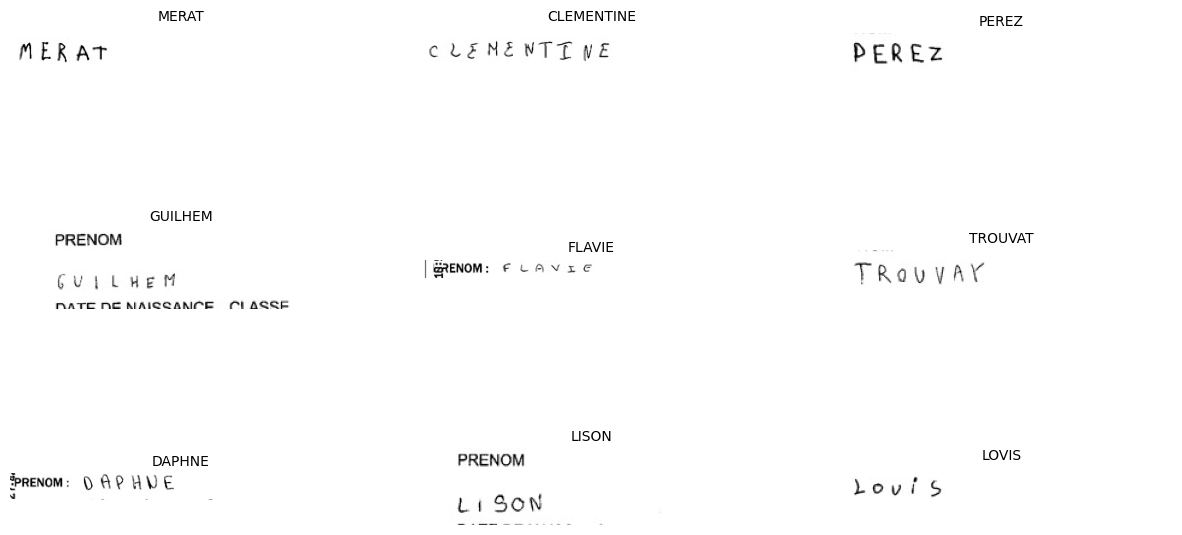

In [3]:
def visualization_data(data_csv, image_dir):
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the bounding boxes
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.randint(0, 1000)
        # Load the image
        image_path = os.path.join(image_dir, data_csv.loc[idx, 'FILENAME'])
        image = cv2.imread(image_path, 0)
        axs[row, col].imshow(image, cmap = 'gray')
        axs[row, col].set_title(data_csv.loc[idx, 'IDENTITY'], fontsize=10)
        axs[row, col].axis('off')
    plt.show()
    
visualization_data(train_csv, train_img_dir)

## Cleaning Data
Remove the data rows with IDENTITY = 'UNREADABLE'.

In [4]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE']
print(train_csv.shape[0], val_csv.shape[0])

330859 41358


## Preprocessing
* The images are loaded as grayscale and reshaped to width 256 and height 64.

### To preprocess the output labels use the followings:
* Read the text from the IDENTITY column of csv file.
* Encode each character of a word into some numerical value by creating a function as {‘a’:0, ‘b’:1 …….. ‘z’:26} etc.
* Compute the maximum length from words and pad every output label to make it of the same size as the maximum length. This is done to make it compatible with the output shape of our RNN architecture.

In [5]:
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64 # max length of predicted labels: 64
batch_size = 512

def encode_to_label(text):
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx!=-1 else alphabets.find('-'))
    
    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

name = 'QUY DAU'
print(name, '\n', encode_to_label(name))

QUY DAU 
 [16 20 24 27  3  0 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [7]:
def decode_to_text(number_arr):
    text = ''
    for number in number_arr:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

decode_to_text([16, 20, 24, 27, 3, 0, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

'QUY DAU'

## Use generator for same purpose
* data_y contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
* label_len contains the length of each true label (without padding)
* input_len contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.
* output is a dummy output for ctc loss.

In [10]:
@tf.function
def preprocess_image(image_path, label, label_len):
    # Read image
    file = tf.io.read_file(image_path)
    # Decode and convert to grayscale
    image = tf.image.decode_png(file, channels=1)
    # Convert to float32 in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, [64, 256])
    # Compute the input_len
    input_len = [num_of_timestamps - 2]
    
    return image, label, input_len, label_len, [0]

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function for Create list of image data
def create_data_list(data_csv, img_dir):
    data_x, data_y, label_len = [], [], []
    for idx, row in data_csv.iterrows():
        if isinstance(row['IDENTITY'], str):
            data_x.append(os.path.join(img_dir, row['FILENAME']))
            text = row['IDENTITY'].upper()
            data_y.append(encode_to_label(text))
            label_len.append(len(text))
        
    return data_x, data_y, label_len

# Function for Create tensorflow dataset
def create_tf_dataset(data_x, data_y, label_len):
    dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y, label_len))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
    dataset = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [12]:
# Create tensorflow Dataset for train data
train_x, train_y, train_label_len = create_data_list(train_csv, train_img_dir)
train_dataset = create_tf_dataset(train_x, train_y, train_label_len)

# Create tensorflow Dataset for val data
val_x, val_y, val_label_len = create_data_list(val_csv, val_img_dir)
val_dataset = create_tf_dataset(val_x, val_y, val_label_len)

print(len(train_y), len(val_y))

330294 41280


## Model Training
Our model consists of three parts:
1. The convolutional neural network to extract features from the image.
2. Recurrent neural network to predict sequential output per time-step.
3. CTC loss function which is transcription layer used to predict output for each time step.

### Loss function
Here, we are using the CTC loss function. CTC loss is very helpful in text recognition problems. It helps us to prevent annotating each time step and help us to get rid of the problem where a single character can span multiple time step which needs further processing if we do not use CTC.

A CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. To get this we need to create a custom loss function and then pass it to the model. To make it compatible with our model, we will create a model which takes these four inputs and outputs the loss.

In [13]:
# Defining the CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [14]:
# Define the Convolutional Block
def conv_block(num_filters, use_max_pool=True, pool_size=(4, 2), stride=2):
    cnn = Sequential()
    cnn.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=pool_size, strides=stride))
    return cnn
    
# Define the CRNN Model
def CRNN():
    # Inputs
    inputs = Input(shape=(64, 256, 1), name='image')
    labels = Input(name="label", shape=(None,), dtype="float32")
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    # CNN
    conv1 = conv_block(32)(inputs)
    conv2 = conv_block(64)(conv1)
    conv3 = conv_block(128, pool_size=(4, 1), stride=1)(conv2)
    conv4 = conv_block(256, pool_size=(4, 1), stride=1)(conv3)
    conv5 = conv_block(128, pool_size=(5, 1), stride=1)(conv4)
    
    # CNN --> RNN
    reshape = Reshape((num_of_timestamps, 512))(conv5)
    dense = Dense(num_of_timestamps, activation='relu')(reshape)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.2)(bn)
    
    # RNN
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(dropout)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(lstm1)
    
    # Outputs
    y_pred = Dense(num_of_characters, activation = 'softmax')(lstm2)
    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    pred_model = Model(inputs=inputs, outputs=y_pred)
    train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)
    
    return pred_model, train_model

model, train_model = CRNN()
train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 31, 128, 32)  448         ['image[0][0]']                  
                                                                                                  
 sequential_1 (Sequential)      (None, 14, 64, 64)   18752       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 11, 64, 128)  74368       ['sequential_1[0][0]']     

# Training the Model
To train the model we will use Adam optimizer. Also, we can use Keras callbacks functionality to save the weights of the best model on the basis of validation loss.

In [15]:
# Compile the model
train_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

filepath = "/kaggle/working/best_model.h5"

# function callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor= 'val_loss',
                             verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

earlyStopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callbacks_list = [checkpoint, earlyStopping]

# method 1
history = train_model.fit(train_dataset,
                          epochs=30,
                          validation_data=val_dataset,
                          verbose = 1,
                          shuffle=True, 
                          callbacks=callbacks_list)

# Save the model
model.save('/kaggle/working/my_model.h5')

Epoch 1/30
646/646 [==============================] - ETA: 0s - loss: 11.5920
Epoch 1: val_loss improved from inf to 8.30842, saving model to /kaggle/working/best_model.h5
646/646 [==============================] - 1067s 2s/step - loss: 11.5920 - val_loss: 8.3084
Epoch 2/30
646/646 [==============================] - ETA: 0s - loss: 3.4520
Epoch 2: val_loss did not improve from 8.30842
646/646 [==============================] - 453s 700ms/step - loss: 3.4520 - val_loss: 9.9281
Epoch 3/30
646/646 [==============================] - ETA: 0s - loss: 2.7256
Epoch 3: val_loss improved from 8.30842 to 2.35151, saving model to /kaggle/working/best_model.h5
646/646 [==============================] - 427s 661ms/step - loss: 2.7256 - val_loss: 2.3515
Epoch 4/30
646/646 [==============================] - ETA: 0s - loss: 2.3471
Epoch 4: val_loss did not improve from 2.35151
646/646 [==============================] - 435s 673ms/step - loss: 2.3471 - val_loss: 3.0898
Epoch 5/30
646/646 [==============

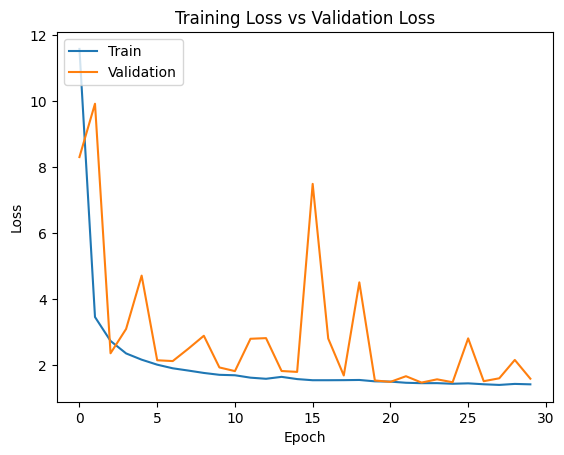

In [34]:
# Visualize the training process

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Validation the Model in validation data

In [17]:
# Load the best model
model.load_weights('/kaggle/working/best_model.h5')

In [18]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indices = np.argmax(predictions, axis=2)
    
    for i in range(pred_indices.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indices[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(alphabets):
                ans += alphabets[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [28]:
def get_predictions_and_labels(dataset, model):
    """
    Input: Tensorflow Dataset and the model to predict
    Output: Extract labels from dataset and get prediction from the model
    """
    predictions, labels = [], []
    for batch in dataset.as_numpy_iterator():
        images, num_labels = batch[0][0], batch[0][1]
        preds = model.predict(images)
        predictions.extend(ctc_decoder(preds))
        labels.extend([decode_to_text(num_labels[i]) for i in range(len(num_labels))])
    
    return predictions, labels

predictions, labels = get_predictions_and_labels(val_dataset, model)
print(len(predictions), len(labels))

10/10 [==============================] - 0s 10ms/step
41280 41280


In [32]:
def get_accuracy_characters_and_words(predictions, labels):
    """
    Input: The predictions and labels text of validation data
    Output: The accuracy about words and characters
    """
    word_accuracy = np.mean([predictions[i] == labels[i] for i in range(len(predictions))])
    num_correct_char, len_char = 0, 0
    for i in range(len(predictions)):
        num_correct_char += np.sum([predictions[i][j] == labels[i][j] for j in range(min(len(predictions[i]), len(labels[i])))])
        len_char += len(labels[i])
    
    character_accuracy = num_correct_char/ float(len_char)
    return word_accuracy, character_accuracy

word_accuracy, character_accuracy = get_accuracy_characters_and_words(predictions, labels)
print('Character accuracy in the validation set: {} %'.format(round(character_accuracy * 100, 3)))
print('Word accuracy in the validation set: {} %'.format(round(word_accuracy * 100, 3)))

Character accuracy in the validation set: 92.719 %
Word accuracy in the validation set: 80.438 %


## Test trained model with the images in test dataset

In [103]:
# Declare image directory and label csv file for the test dataset
test_img_dir = '/kaggle/input/handwriting-recognition/test_v2/test'
test_csv = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

# Create test dataset with TensorFlow format
test_x, test_y, test_label_len = create_data_list(test_csv, test_img_dir)
test_dataset = create_tf_dataset(test_x, test_y, test_label_len)

16/16 [==============================] - 0s 11ms/step


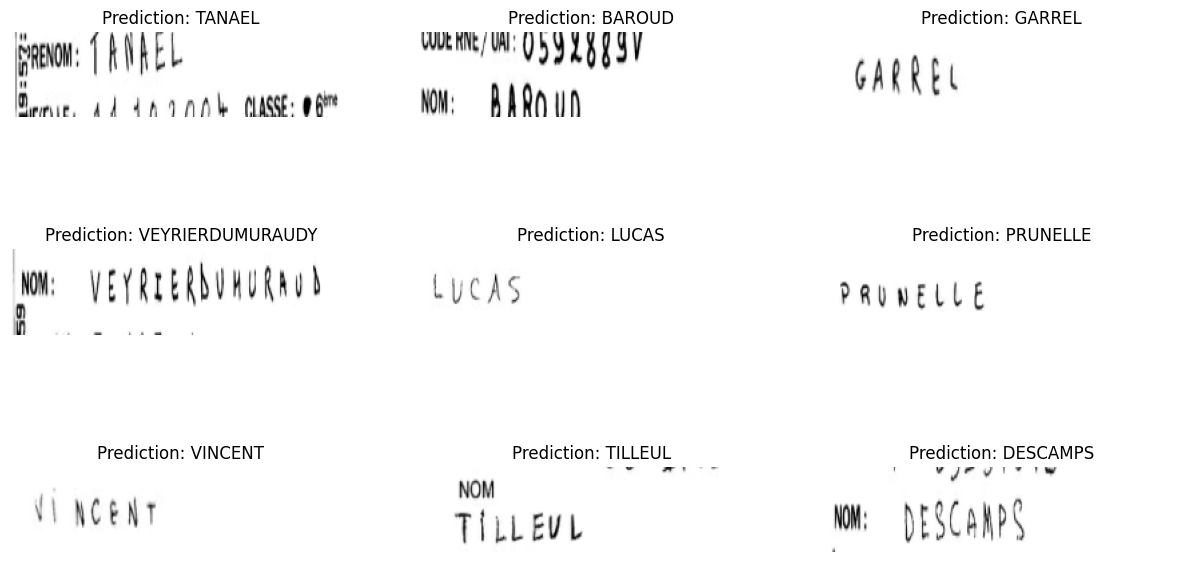

In [107]:
def test_images_data_with_model_prediction(model, dataset):
    # Create predictions for a batch in this dataset
    for batch in dataset.as_numpy_iterator():
        images = batch[0][0]
        predictions = ctc_decoder(model.predict(images))
        break
    
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the image with prediction model
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.randint(0, batch_size)
        axs[row, col].imshow(images[idx], cmap = 'gray')
        axs[row, col].set_title('Prediction: {}'.format(predictions[idx]), fontsize=12)
        axs[row, col].axis('off')
    plt.show()

test_images_data_with_model_prediction(model, test_dataset)

WEBCAM CODE

In [ ]:
import numpy as np
import cv2
font_scale= 1.5
font = cv2.FONT_HERSHEY_PLAIN
import pytesseract

cap = cv2.VideoCapture(1)

if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
cntr=0;
while True:
    ret,frame = cap.read()
    cntr=cntr+1;
    if((cntr%20)==0):
        
        imgH,imgW, _ = frame.shape
        x1,y1,w1,h1 = 0,0,imgH,imgW
        imgchar = pytesseract.image_to_string(frame)
        imgboxes = pytesseract.image_to_boxes(frame)
        for boxes in imgboxes.splitlines():
            boxes= boxes.split(' ')
            x,y,w,h = int(boxes[1]),int(boxes[2]),int(boxes[3]),int(boxes[4])
            cv2.rectangle(frame, (x, imgH-y),(w,imgH-h),(0,0,255), 3)
            
            
            cv2.putText(frame, imgchar, (x1 + int(w1/50),y1 + int(h1/50)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0),2)
            font = cv2.FONT_HERSHEY_SIMPLEX
            
            
            cv2.imshow('Text Detection Tutorial',frame)
            
            if cv2.waitKey(2) & 0xFF == ord('q'):
                break
    
cap.release()
cv2.destroyAllWindows()